In [2]:
#Based off Jason Chin's https://github.com/jrobchin/Computer-Vision-Basics-with-Python-Keras-and-OpenCV

## *Imports*

In [48]:
import sys # system functions (ie. exiting the program)
import os # operating system functions (ie. path building on Windows vs. MacOs)
import time # for time operations
import uuid # for generating unique file names
import math # math functions

from IPython.display import display as ipydisplay, clear_output, HTML # for interacting with the notebook better
from PIL import Image

import numpy as np # matrix operations (ie. difference between two matricies)
import cv2 # (OpenCV) computer vision functions (ie. tracking)
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

import matplotlib.pyplot as plt # (optional) for plotting and showing images inline
%matplotlib inline

import keras # high level api to tensorflow (or theano, CNTK, etc.) and useful image preprocessing
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

OpenCV Version: 4.4.0
Keras image data format: channels_last


## *Constants*

In [49]:
MODEL_PATH = os.path.join('model')
MODEL_FILE = os.path.join(MODEL_PATH, 'signal_model.hdf5') # path to model weights and architechture file
MODEL_HISTORY = os.path.join(MODEL_PATH, 'model_history.txt') # path to model training history

## *Tracking*

For this implementation we chose to use the Kernelized Correlation Filters (KCF) tracking since we worked with someone that has experience with it and it has error detection.

In [25]:
# Set up tracker.
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if tracker_type == 'BOOSTING':
        tracker = cv2.TrackerBoosting_create()
    if tracker_type == 'MIL':
        tracker = cv2.TrackerMIL_create()
    if tracker_type == 'KCF':
        tracker = cv2.TrackerKCF_create()
    if tracker_type == 'TLD':
        tracker = cv2.TrackerTLD_create()
    if tracker_type == 'MEDIANFLOW':
        tracker = cv2.TrackerMedianFlow_create()
    if tracker_type == 'GOTURN':
        tracker = cv2.TrackerGOTURN_create()
    
    return tracker

## *Sign Language Recognition*
### Objective
Use computer vision to track a user's hand to recognize Sign Language Hand Signs.

### Extracting the subject

The user is first extracted from the background to make tracking more effective and make it easier on the algorithm to recognize the signs.

The first frame is taken as the background frame (or reset the it by pressing 'r'). Then the frame difference will be taken to figure out the hand sing.

### Tracking the hand
    
A box is displayed that allows user to hit 't' to begin tracking. Everytime 's' is hit a screen capture of the cropped hand is saved.

### Collecting data

This network is trained on the mask to reduce dimensionality while sacrificing information stored in the colours of an image.

In [50]:
def data_collection(position, data_type):
    classes = {
        0: 'a',
        1: 'b',
        2: 'c',
        3: 'd'
    }

    CURR_POSE = position
    DATA = data_type

    # Helper function for applying a mask to an array
    def mask_array(array, imask):
        if array.shape[:2] != imask.shape:
            raise Exception("Shapes of input and imask are incompatible")
        output = np.zeros_like(array, dtype=np.uint8)
        for i, row in enumerate(imask):
            output[i, row] = array[i, row]
        return output

    # Begin capturing video
    video = cv2.VideoCapture(0)
    if not video.isOpened():
        print("Could not open video")
        sys.exit()

    # Read first frame
    ok, frame = video.read()
    if not ok:
        print("Cannot read video")
        sys.exit()
    # Use the first frame as an initial background frame
    bg = frame.copy()

    # Kernel for erosion and dilation of masks
    kernel = np.ones((3,3),np.uint8)

    # Tracking
    # Bounding box -> (TopRightX, TopRightY, Width, Height)
    bbox_initial = (70, 70, 200, 200)
    bbox = bbox_initial
    # Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
    tracking = -1

    # Text display positions
    positions = {
        'hand_pose': (15, 40),
        'fps': (15, 20)
    }

    # Image count for file name
    img_count = 0

    # Capture, process, display loop    
    while True:
        # Read a new frame
        ok, frame = video.read()
        display = frame.copy()
        if not ok:
            break

        # Start timer
        timer = cv2.getTickCount()

        # Processing
        # First find the absolute difference between the two images
        diff = cv2.absdiff(bg, frame)
        mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        # Threshold the mask
        th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
        # Opening, closing and dilation
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
        img_dilation = cv2.dilate(closing, kernel, iterations=2)
        # Get mask indexes
        imask = img_dilation > 0
        # Get foreground from mask
        foreground = mask_array(frame, imask)
        foreground_display = foreground.copy()

        # If tracking is active, update the tracker
        if tracking != -1:
            tracking, bbox = tracker.update(foreground)
            tracking = int(tracking)

        # Use numpy array indexing to crop the foreground frame
        hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]

        # Draw bounding box
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(foreground_display, p1, p2, (0, 255, 0), 2, 1)
        cv2.rectangle(display, p1, p2, (0, 255, 0), 2, 1)

        # Calculate Frames per second (FPS)
        fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
        # Display FPS on frame
        cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
        cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)

        # Display result
        cv2.imshow("display", display)
        # Display diff
        cv2.imshow("diff", diff)
        # Display thresh
        cv2.imshow("thresh", thresh)
        # Display mask
        cv2.imshow("img_dilation", img_dilation)
        try:
            # Display hand_crop
            cv2.imshow("hand_crop", hand_crop)
        except:
            pass
        # Display foreground_display
        cv2.imshow("foreground_display", foreground_display)

        k = cv2.waitKey(1) & 0xff

        if k == 27: break # ESC pressed
        elif k == 114 or k == 112: 
            # r pressed
            bg = frame.copy()
            bbox = bbox_initial
            tracking = -1
        elif k == 116:
            # t pressed
            # Initialize tracker with first frame and bounding box
            tracker = setup_tracker(2)
            tracking = tracker.init(frame, bbox)
        elif k == 115:
            # s pressed
            img_count += 1
            fname = os.path.join(DATA, CURR_POSE, "{}_{}.jpg".format(CURR_POSE, img_count))
            cv2.imwrite(fname, hand_crop)
        elif k != 255: print(k)

    cv2.destroyAllWindows()
    video.release()

In [55]:
#test_data` or validation_data
data_collection('a', 'training_data')

### Building the Neural Network

This is a  simple convolutional neural network containing three convolutional and max pooling layers.

In [28]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(54, 54, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Preparing Data for Training

The keras data generator augments data, improving generalization of the model.

The flow_from_directory() method prepares classification data according to file directories.

In [46]:
batch_size = 16

training_datagen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=10)

training_generator = training_datagen.flow_from_directory(
    'training_data',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(
    'validation_data',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale'
)

Found 2008 images belonging to 5 classes.
Found 194 images belonging to 5 classes.


### Training

In [ ]:
model.fit_generator(
    generator=training_generator,
    steps_per_epoch=2000 // batch_size,
    epochs=50,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=200 // batch_size,
    workers=8,
)

### Plotting Model History

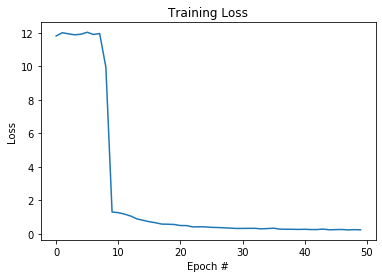

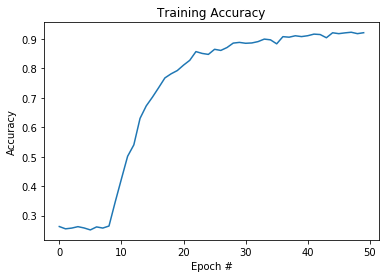

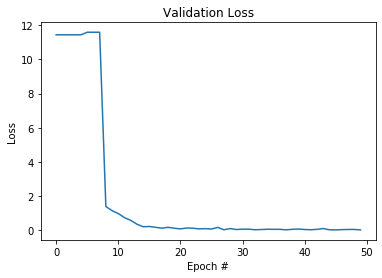

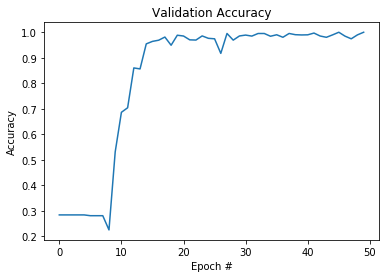

In [47]:
import re
with open(MODEL_HISTORY) as history_file:
    history = history_file.read()

data = {}

data['acc'] = re.findall(' acc: ([0-9]+\.[0-9]+)', history)
data['loss'] = re.findall(' loss: ([0-9]+\.[0-9]+)', history)
data['val_acc'] = re.findall(' val_acc: ([0-9]+\.[0-9]+)', history)
data['val_loss'] = re.findall(' val_loss: ([0-9]+\.[0-9]+)', history)

for key, values in data.items():
    for i, val in enumerate(values):
        values[i] = float(val)

plt.figure()
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['loss'])


plt.figure()
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['acc'])


plt.figure()
plt.title("Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['val_loss'])


plt.figure()
plt.title("Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['val_acc'])

In [43]:
# model.save("signal_model.hdf5")